# Examples from MIMIC-CXR

## Class: Lung Opacity

In [65]:
from medvqa.utils.files import load_pickle
from medvqa.datasets.mimiccxr import load_mimiccxr_reports_detailed_metadata
from tqdm import tqdm
import random

In [26]:
metadata = load_mimiccxr_reports_detailed_metadata()

In [2]:
aux = load_pickle('/mnt/data/pamessina_folder_backup_15_10_24/pamessina/medvqa-workspace/cache/mimiccxr_dicom_id_to_pos_neg_facts(num_rel_facts=317035,num_clusters=100,max_neg=500,ent_th=0.172)(hash=1200,2067390724509563020).pkl')

In [3]:
tmp = load_pickle("/mnt/data/pamessina_folder_backup_15_10_24/pamessina/medvqa-workspace/cache/mimiccxr_find_facts_relevant_to_anchor_facts(af=25,rf=317035)(hash=411,354564789477999375).pkl")

In [6]:
dicom_id_to_pos_facts = aux['dicom_id_to_pos_facts']
dicom_id_to_strong_neg_facts = aux['dicom_id_to_strong_neg_facts']
dicom_id_to_weak_neg_facts = aux['dicom_id_to_weak_neg_facts']

In [34]:
anchor_idx = tmp['anchor_facts'].index('Lung Opacity')
anchor_idx

12

In [17]:
anchors_per_fact = tmp['anchors_per_fact']
rf2idx = {f:i for i, f in enumerate(tmp['relevant_facts'])}
fact_idx_to_rel_fact_idx = [rf2idx[f] if f in rf2idx else None for f in aux['facts']]

In [30]:
dicom_id_to_ridx = {}
for ridx, dicom_id_view_pos_pairs in enumerate(metadata['dicom_id_view_pos_pairs']):
    for dicom_id, _ in dicom_id_view_pos_pairs:
        assert dicom_id not in dicom_id_to_ridx
        dicom_id_to_ridx[dicom_id] = ridx

In [36]:
def has_anchor(fidxs, aidx):
    for fidx in fidxs:
        rfidx = fact_idx_to_rel_fact_idx[fidx]
        for a in anchors_per_fact[rfidx]:
            if a == aidx:
                return True
    return False

def get_report_idxs_with_anchor(dicom_id_to_facts, aidx):
    seen_ridxs = set()
    ridxs_with_anchor = []
    for dicom_id, facts in tqdm(dicom_id_to_facts.items(), mininterval=2):
        ridx = dicom_id_to_ridx[dicom_id]
        if ridx in seen_ridxs:
            continue
        seen_ridxs.add(ridx)
        if has_anchor(facts, aix):
            ridxs_with_anchor.append(ridx)
    print(f'len(ridxs_with_anchor) = {len(ridxs_with_anchor)}')
    return ridxs_with_anchor

In [37]:
pos_report_idxs_with_anchor = get_report_idxs_with_anchor(dicom_id_to_pos_facts, anchor_idx)

100%|███████████████████████████████████████████████████████████████████████| 377110/377110 [00:00<00:00, 440620.89it/s]

len(ridxs_with_anchor) = 70092


In [38]:
strong_neg_report_idxs_with_anchor = get_report_idxs_with_anchor(dicom_id_to_strong_neg_facts, anchor_idx)

100%|███████████████████████████████████████████████████████████████████████| 377110/377110 [00:00<00:00, 504821.56it/s]

len(ridxs_with_anchor) = 23517


In [39]:
weak_neg_report_idxs_with_anchor = get_report_idxs_with_anchor(dicom_id_to_weak_neg_facts, anchor_idx)

100%|████████████████████████████████████████████████████████████████████████| 377110/377110 [00:14<00:00, 25596.11it/s]

len(ridxs_with_anchor) = 157743


In [45]:
conflicting_ridxs = list(set(pos_report_idxs_with_anchor) & set(strong_neg_report_idxs_with_anchor))
len(conflicting_ridxs)

6544

In [59]:
from medvqa.datasets.mimiccxr import get_mimiccxr_large_image_path
from medvqa.utils.files import read_txt

In [70]:
def get_report_text_and_images(ridx):
    part_id = metadata['part_ids'][ridx]
    subject_id = metadata['subject_ids'][ridx]
    study_id = metadata['study_ids'][ridx]
    dicom_id_view_pos_pairs = metadata['dicom_id_view_pos_pairs'][ridx]
    image_paths = [get_mimiccxr_large_image_path(part_id, subject_id, study_id, dicom_id) for dicom_id, _ in dicom_id_view_pos_pairs]
    report_text = read_txt(metadata['filepaths'][ridx])
    return report_text, image_paths

In [104]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown
import math

# Function to display the radiology report and images
def visualize_report_and_images(report_text, image_paths):
    # Display the report text
    display(Markdown("### Radiology Report"))
    display(Markdown(f"```\n{report_text.strip()}\n```"))
    
    # Determine grid layout
    max_columns = min(2, len(image_paths))
    num_images = len(image_paths)
    num_rows = math.ceil(num_images / max_columns)
    
    # Create subplots for the grid
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(12, 6 * num_rows), squeeze=False)
    axes = axes.flatten()  # Flatten to simplify iteration
    
    # Load and display images
    for idx, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        axes[idx].imshow(img, cmap="gray")
        axes[idx].axis("off")
    
    # Hide any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

# 1) Examples with Lung Opacity

### Example 1.1

ridx: 150204
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p16/p16065424/s50656995/f779f5d4-3f82f8a1-5ebc6512-e302058a-baccbe61.jpg


### Radiology Report

```
WET READ: ___ ___ ___ 8:22 PM
  Enteric tube in the stomach with distal tip not captured on the current study.
  No other significant change from the prior study.
 ______________________________________________________________________________
                                 FINAL REPORT
 REASON FOR EXAMINATION:  Evaluation of the patient after NG tube placement.
 
 AP radiograph of the chest was reviewed in comparison ___.
 
 The NG tube tip is in the stomach.  Heart size and mediastinum are overall
 unchanged.  There is mild vascular congestion, but no overt pulmonary edema. 
 Left retrocardiac opacity is unchanged, potentially reflecting atelectasis.
```

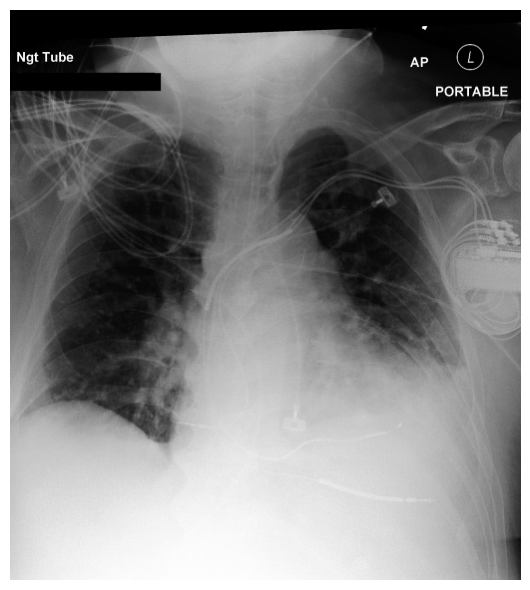

In [105]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.2

ridx: 145317
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p16/p16262919/s51802660/6da907fa-6586f2f8-88e39a07-08986b6a-b804d61b.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old woman with CHF, CKD, p/w worsening cough  // Rule out
 pneumonia, pulm edema      Rule out pneumonia, pulm edema
 
 IMPRESSION: 
 
 Comparison to ___.  In the interval, the lung volumes have decreased. 
 The size of the cardiac silhouette continues to be mildly enlarged.  The
 current radiograph shows signs of mild pulmonary edema.  In addition, there is
 a new parenchymal opacity at the left lung bases, the asymmetry of the change
 suggests pneumonia in the appropriate clinical setting.  No larger pleural
 effusions.  No pneumothorax.
```

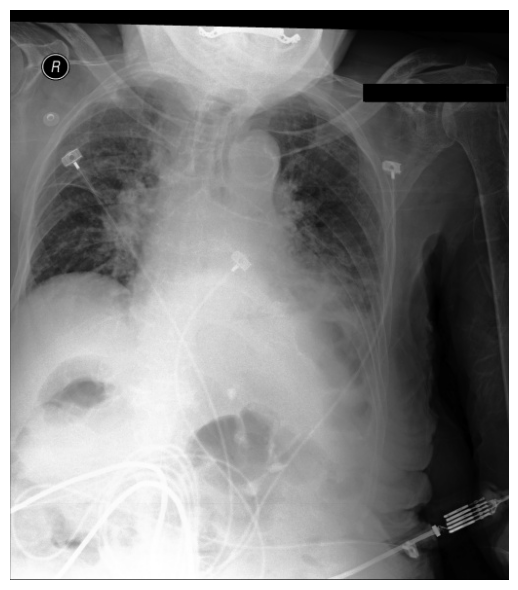

In [106]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.3

ridx: 113308
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14061397/s53107391/b0223f99-ebf92e14-9022721f-a80563e0-b5df522d.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old man with somolence, hypoxia, minor crackles  // r/o
 acute pna
 
 TECHNIQUE:  Portable chest
 
 COMPARISON:  ___
 
 FINDINGS: 
 
 The appearance of the large bore catheter are with stent is unchanged. There
 is volume loss most marked in the retrocardiac region is similar in appearance
 compared to prior an underlying infiltrate in the retrocardiac region cannot
 be excluded. This also increased opacity at the right base slightly more
 prominent than prior.
 
 IMPRESSION: 
 
 Volume loss in both lower lobes. An underlying infectious infiltrate can't be
 excluded.  Appearance is slightly worse compared to prior
```

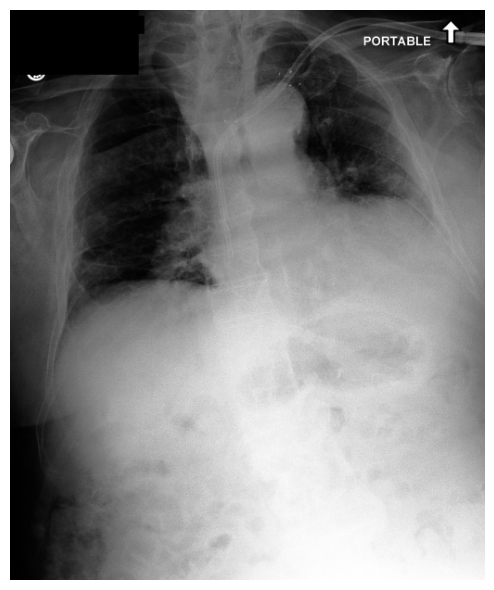

In [73]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.4

ridx: 105231
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14365923/s56974363/24455a53-2097ada3-c25cde8f-18be206c-1aa1d7f8.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14365923/s56974363/8a39306e-a2979f90-f6f04b3d-53f388d7-513c46b1.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:  CHEST (PA AND LAT)
 
 INDICATION:  ___-year-old woman with metastatic breast cancer and pleurex
 catheter on the right.  Evaluate lung fields bilat and compare to recent prior
 imaging.
 
 COMPARISON:  Portable chest radiograph dated ___.
 
 FINDINGS: 
 
 Overall progression of findings compared to the prior exam. Increase in size
 of the known right pleural effusion, now large-to-moderate. New increased
 opacity in the left lingula and lower lung with a small left pleural effusion.
 It is unclear if right-sided lower lung opacities are also present given the
 concurrent right pleural effusion. Increased bilateral pulmonary vascular
 congestion and interstitial pulmonary edema. The right Pleur-ex catheter lies
 within the right hemithorax, although the precise location of tip cannot be
 ascertained.  No pneumothorax. Probable cardiomegaly, although the heart
 borders are obscured by the overlying pleural effusions. The port-A-Cath
 appears unchanged in position and intact.
 
 IMPRESSION: 
 
 1.  Progression of the known right pleural effusion, now large-to-moderate,
 and a new small left pleural effusion.
 
 2.  New, more prominent opacities in the left lingula and lower lung, which
 may be secondary to pulmonary edema.  However, some more unilateral appearance
 raises the possibility of superimposed consolidation.
 
 3.  Interval resolution of the right pneumothorax.
 
 4.  Pulmonary edema.
 
 NOTIFICATION:   The impression above was entered by Dr. ___ on
 ___ at 14:36 into the Department of Radiology critical communications
 system for direct communication to the referring provider.
```

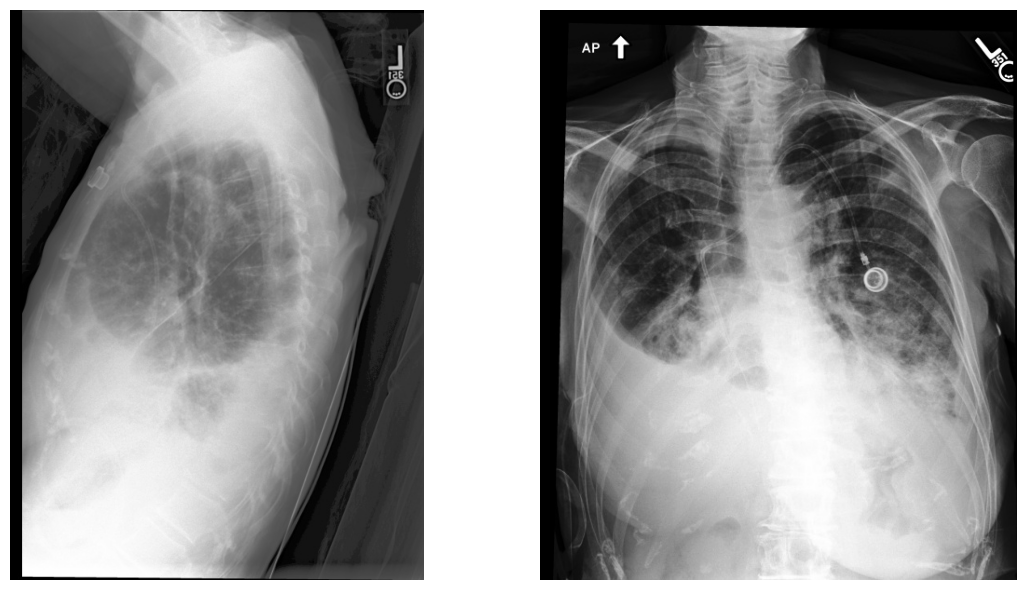

In [74]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.5

ridx: 70397
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13395599/s59578892/2c0af46c-6651dac6-c561b0ec-bd79b737-187c0c93.jpg


### Radiology Report

```
FINAL REPORT
 AP CHEST, 6:47 P.M., ___
 
 HISTORY:  ___-year-old woman with dementia and sudden hypoxia.
 
 IMPRESSION:  AP chest compared to ___:
 
 The suggestion of new region of peribronchial opacification in the right lower
 lobe on ___ is unchanged or smaller.  There is no new consolidation. 
 Pulmonary vascular congestion has improved, severe cardiomegaly has not.  Note
 is made of an extremely heavily calcified mitral annulus, which could
 contribute to mitral regurgitation.  Pleural effusions are small if any.  No
 pneumothorax.
```

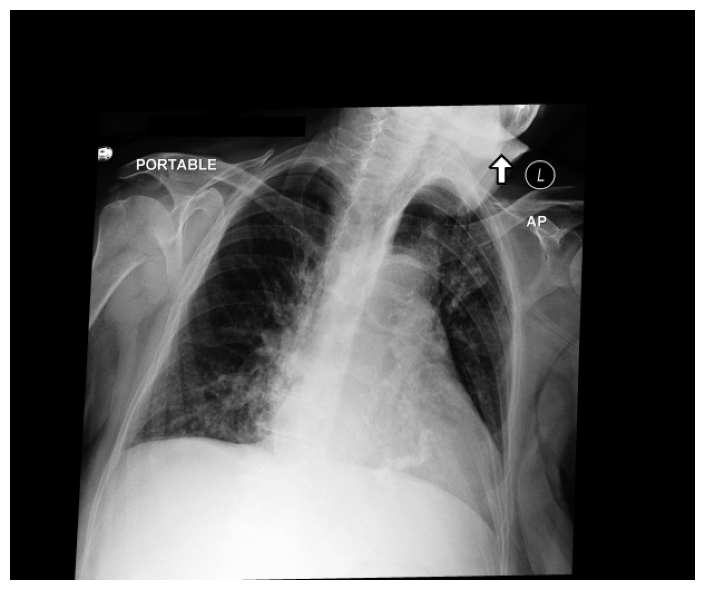

In [107]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.6

ridx: 226859
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19830694/s52696053/533d0e90-311eb3d4-399494a0-7664a53f-ff615cdc.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19830694/s52696053/537011b3-43c5047f-7039c01c-c6c7f371-8ef9ca2a.jpg


### Radiology Report

```
FINAL REPORT
 AP CHEST, 5:18 A.M., ___  
 
 HISTORY:  Renal transplant.  Rule out pneumonia.
 
 IMPRESSION:  AP chest compared to ___:
 
 Severe pulmonary edema and large left pleural effusion have worsened, now
 accompanied by moderate right pleural effusion.  Given the marked
 opacification of both lungs by edema, pneumonia would not be detectable. 
 Large heart and mediastinal venous engorgement are unchanged.  Tracheostomy
 tube in standard placement.  Upper enteric drainage tube passes into
 non-distended stomach and out of view.  There is a new probe in the esophagus,
 ending at the level of the carina.  Left jugular line has been withdrawn
 slightly, more peripheral location in the left brachiocephalic vein.
 
 Dr. ___ was paged to report these findings, at 9:15 a.m.
```

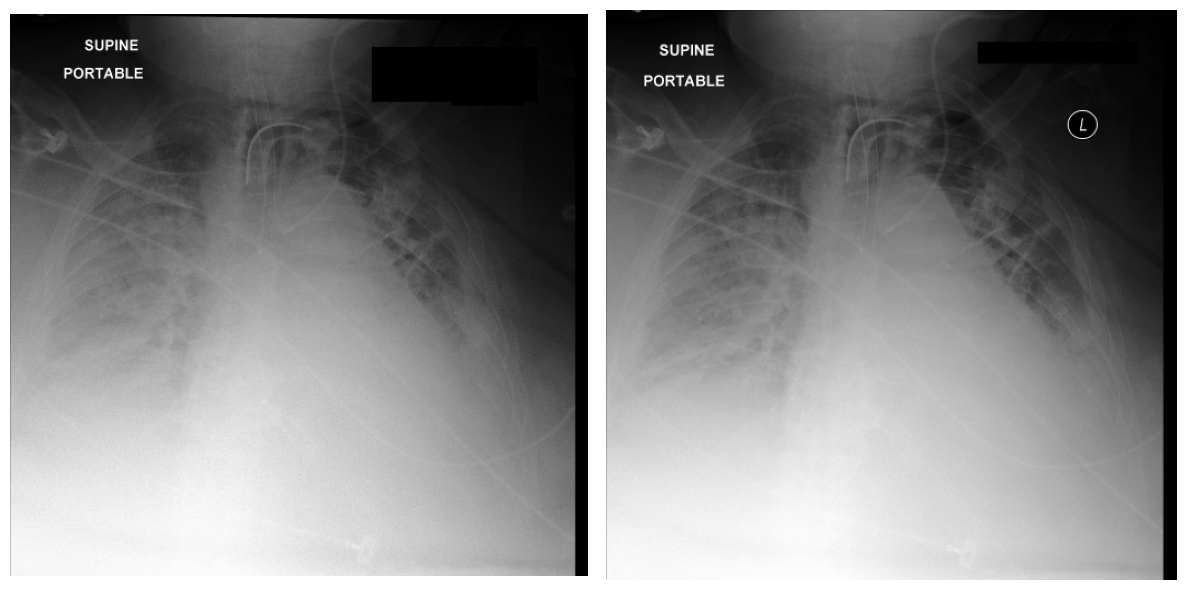

In [108]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.7

ridx: 111786
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14476373/s53343726/6cd8d98f-1b3ee5b1-5b6713e8-7f48c9fe-5ca6c7f1.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14476373/s53343726/d7476085-755683dd-165a0436-199c0735-c60454cb.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14476373/s53343726/f231fe18-30e5023f-617d5710-b7343694-658d8c59.jpg


### Radiology Report

```
FINAL REPORT
 HISTORY:  ___-year-old male with right-sided weakness.
 
 COMPARISON:  None.
 
 FINDINGS:
 
 AP and lateral views of the chest.  Streaky retrocardiac opacities are most
 suggestive of atelectasis.  The lungs are hyperinflated but otherwise clear
 without effusion or consolidation.  Cardiac silhouette is mildly enlarged. 
 Descending thoracic aorta is tortuous.  No acute osseous abnormalities
 detected.
 
 IMPRESSION:
 
 No acute cardiopulmonary process.
```

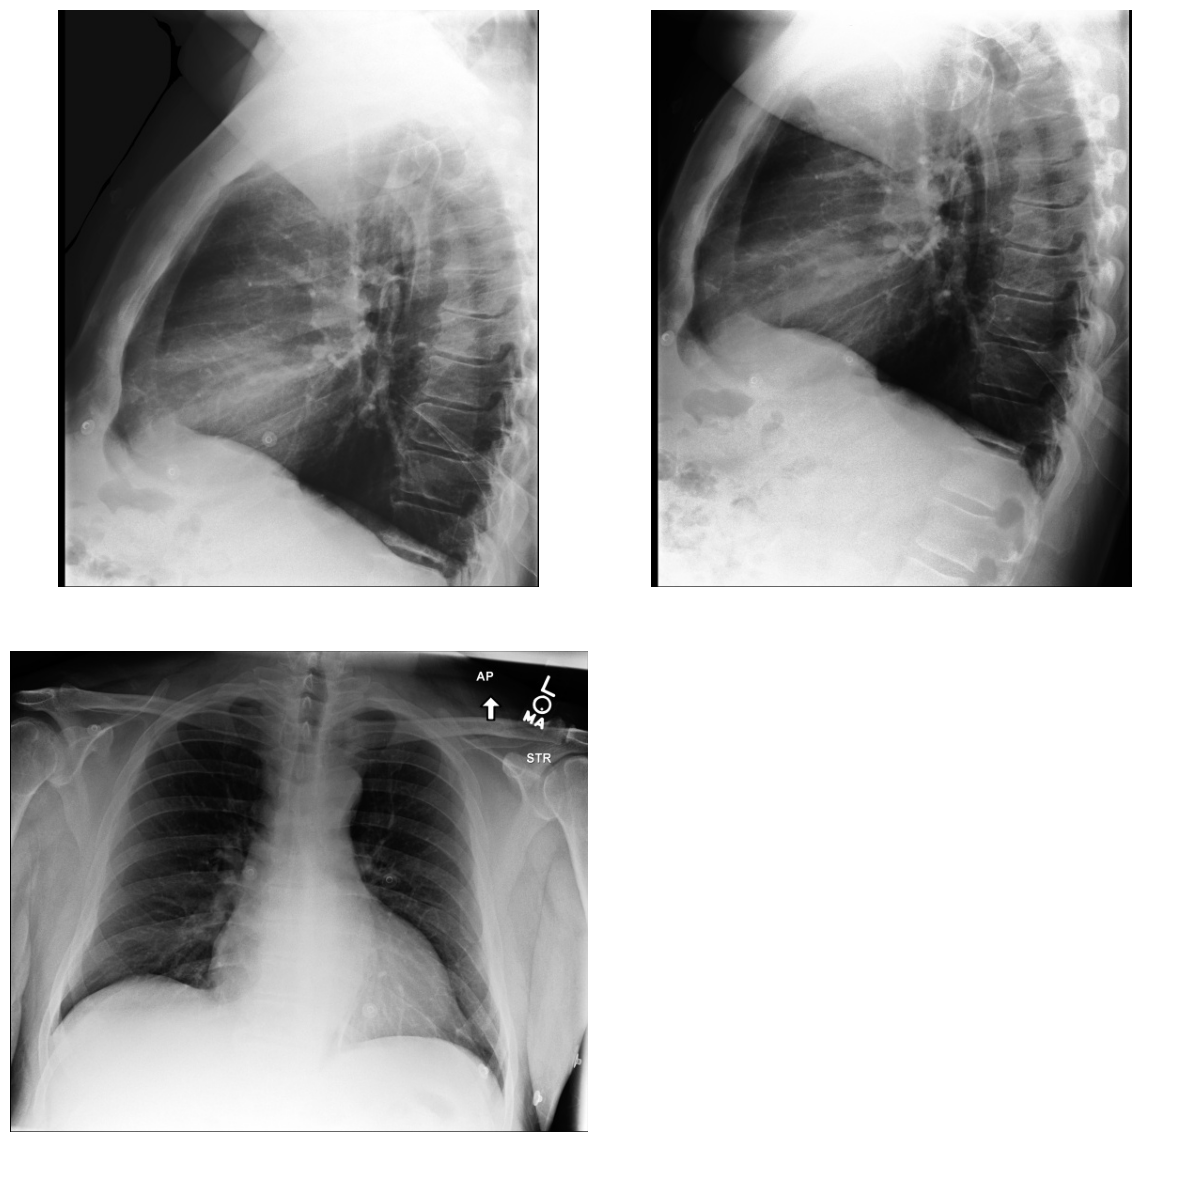

In [109]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 1.8

ridx: 220732
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19059275/s54771449/50edc107-031b1676-f5462785-152b0858-90c674f9.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19059275/s54771449/b48acf65-a8e58e2f-279dce59-ecf6d3e0-97d9e589.jpg


### Radiology Report

```
FINAL REPORT
 INDICATION:  ___-year-old male with fever and cough as well as leukocytosis. 
 Question pneumonia.
 
 COMPARISON:  ___.
 
 FINDINGS:  Frontal and lateral views of the chest redemonstrate marked
 asymmetric aeration of the right lung and architectural distortion related to
 prior right upper lobectomy, with posterior surgical rib defects.  There is
 new hazy opacity involving the right lower lung with extension superiorly. 
 Multiple air-fluid levels are present in the right upper lung in the resection
 bed, suggestive of complex loculated fluid, raising question of empyema.  The
 left lung remains clear.  The visualized portion of the cardiomediastinal
 silhouette is within normal limits.  Trace subcutaneous emphysema is
 persistent, likely postoperative residual.
 
 IMPRESSION:
 1.  New hazy opacity involving the right lung with numerous air-fluid levels
 superiorly in the region of recent right upper lobectomy.  This could
 represent infection with associated loculated fluid, however CT would be
 prudent to exclude empyema.
 2.  No radiographic evidence of pneumothorax.
 3.  Diminishing subcutaneous emphysema.
```

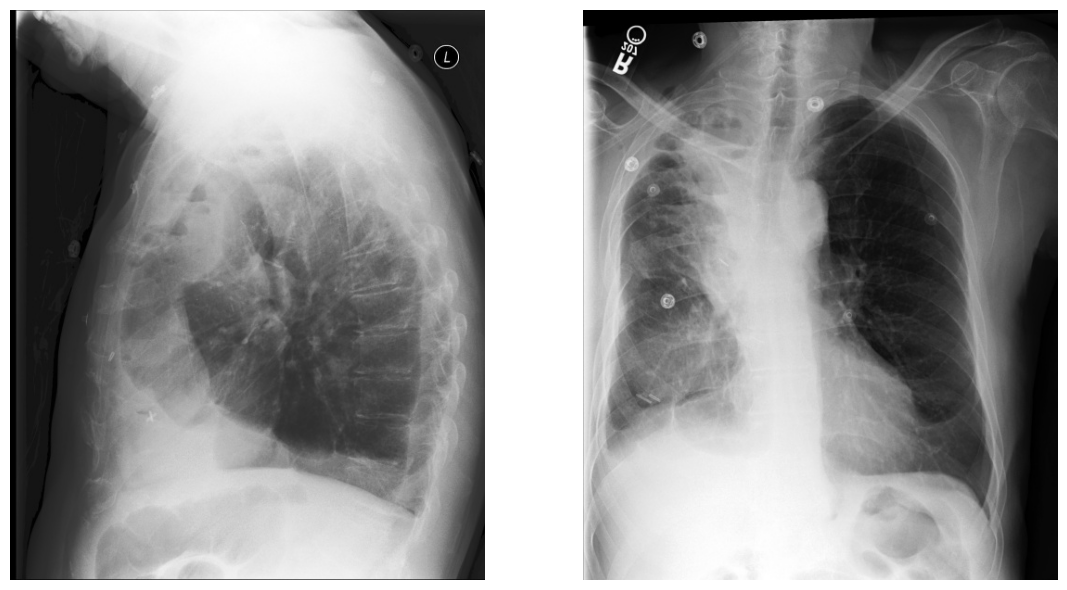

In [80]:
ridx = random.choice(pos_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

# 2) Examples without Lung Opacity

### Example 2.1

ridx: 227226
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19338598/s51281640/18f38269-26ad9d86-4563511e-c8aa8e51-dce5869a.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19338598/s51281640/a9939e01-22af04f8-db3b27ad-8dc8deeb-05980b27.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:  CHEST (PA AND LAT)
 
 INDICATION:  ___M with cough  // acute process?
 
 COMPARISON:  ___
 
 FINDINGS: 
 
 PA and lateral views of the chest provided.   Lungs appear clear though
 volumes are somewhat low.  There is no focal consolidation, effusion, or
 pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous
 structures are intact.  No free air below the right hemidiaphragm is seen.
 
 IMPRESSION: 
 
 No acute intrathoracic process.
```

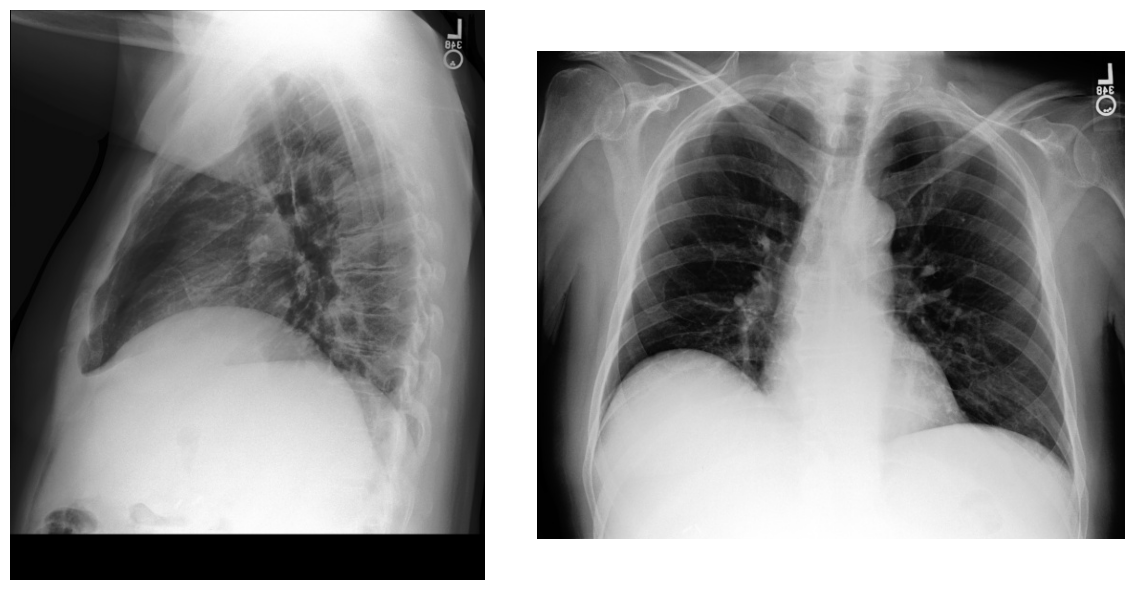

In [84]:
ridx = random.choice(strong_neg_report_idxs_with_anchor)
assert ridx not in conflicting_ridxs
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.2

ridx: 167651
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p17/p17620462/s52419669/0f8b84aa-753e6b9e-8e4aca8b-806e37a6-6edffaef.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p17/p17620462/s52419669/61d63b5d-17051776-37e7d658-40bbccaa-8dc56ce0.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:
 Chest:  Frontal and lateral views
 
 INDICATION:  History: ___M with  pain with breathibng and moving arm  // r/o fx
 rib
 
 TECHNIQUE:  Chest:  Frontal and Lateral
 
 COMPARISON:  None.
 
 FINDINGS: 
 
 The lungs are clear without focal consolidation.  No pleural effusion or
 pneumothorax is seen. The cardiac and mediastinal silhouettes are
 unremarkable.  No displaced rib fracture is identified.
 
 IMPRESSION: 
 
 No acute cardiopulmonary process.  No displaced rib fracture is identified;
 however, if high clinical concern for rib fracture persists, dedicated rib
 series or CT is more sensitive.
```

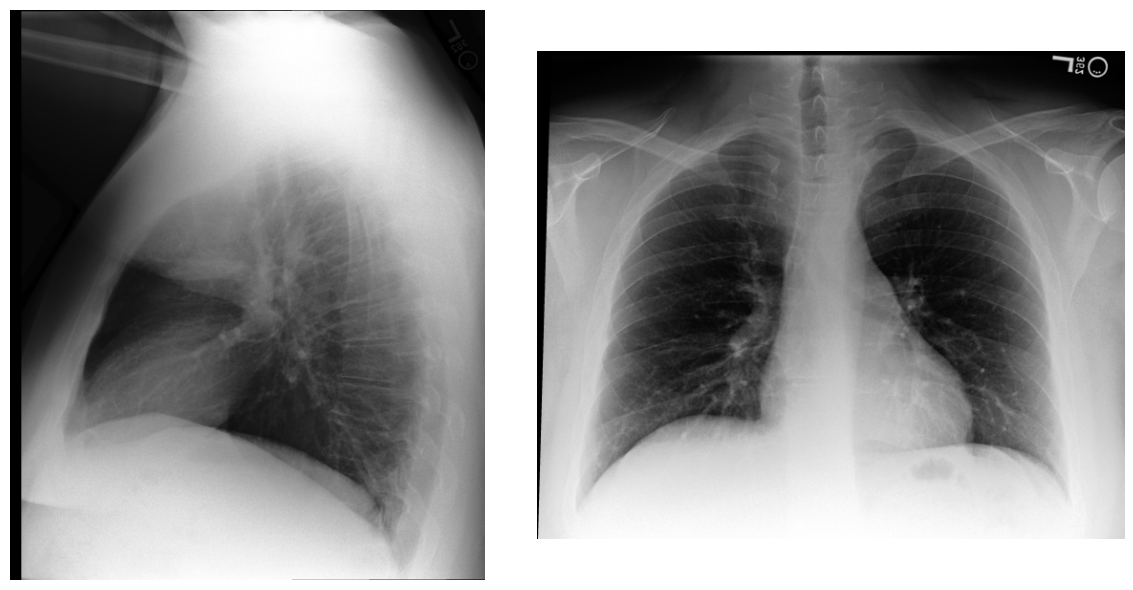

In [85]:
ridx = random.choice(strong_neg_report_idxs_with_anchor)
assert ridx not in conflicting_ridxs
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.3

ridx: 31077
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11948471/s55326009/db97e24f-9cdb542e-ad3e0aa5-2be107fb-cf3ec751.jpg


### Radiology Report

```
FINAL REPORT
 AP CHEST, 9:04 P.M. ON ___
 
 HISTORY:  Tension pneumothorax.  Air leak.
 
 IMPRESSION:  AP chest compared to ___, 3:58 p.m.
 
 Volume of the small residual right pneumothorax is probably unchanged, with
 some pleural fluid replacing air at the base and small residual of pleural air
 at the apex.  Large region of consolidation in the right lower lobe which was
 not present prior to the exacerbation of pneumothorax and its treatment with
 pleural drain has progressed since the earlier study raising concern for
 either rapidly developing pneumonia or pulmonary bleeding.  Left lung is
 clear.  Heart size is increased, but still normal.  Right pleural drainage
 catheter unchanged in its position along the right chest wall.  Subcutaneous
 emphysema in the soft tissues of the axilla, decreasing.  ET tube and upper
 enteric drainage tube in standard placements, unchanged.
```

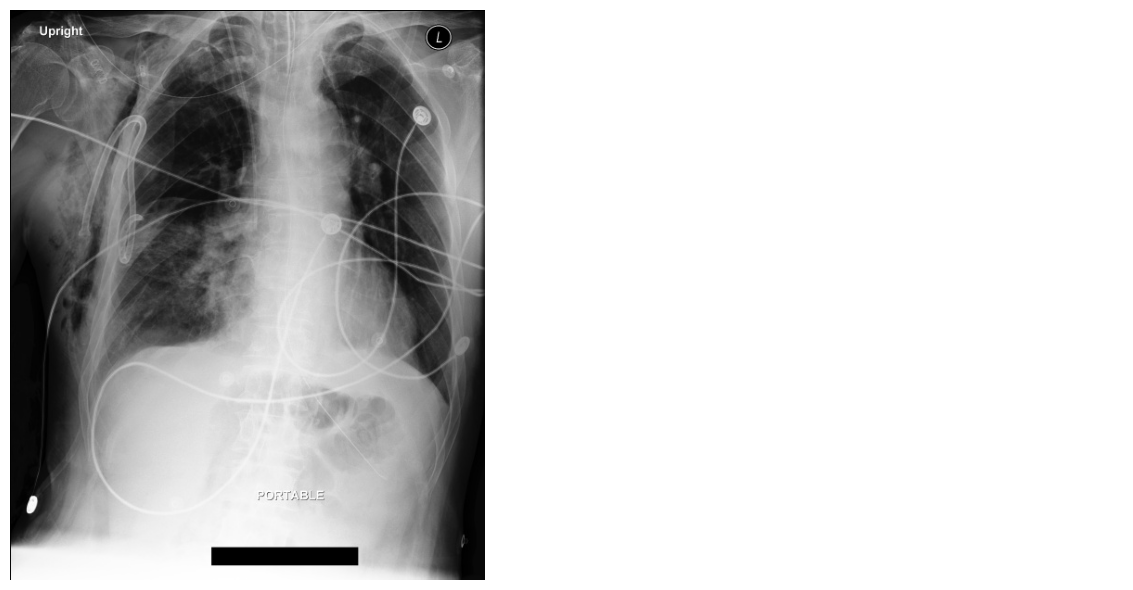

In [88]:
ridx = random.choice(strong_neg_report_idxs_with_anchor)
assert ridx not in conflicting_ridxs
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.4

ridx: 6050
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10211736/s53800582/5c4a9f23-6905cfae-11228a91-936c5852-d9f3e0f1.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10211736/s53800582/717362c7-a721e4a3-8ada2d9a-aa2a82a8-a3281117.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10211736/s53800582/e7b898e8-74884069-5420cbbc-df7e0223-54436407.jpg


### Radiology Report

```
FINAL REPORT
 CHEST, TWO VIEWS, ___
 
 HISTORY:  ___-year-old female with right rib pain on lateral chest and
 posterior chest.  Question pneumothorax or infection.
 
 FINDINGS:  Frontal and lateral views of the chest are compared to previous
 exam from ___.  The lungs remain clear.  Costophrenic angles are
 sharp.  The cardiomediastinal silhouette is within normal limits.  Osseous and
 soft tissue structures are notable for degenerative changes at the bilateral
 glenohumeral joints.  There is no visualized acute fracture.
 
 IMPRESSION:  No acute cardiopulmonary process.
```

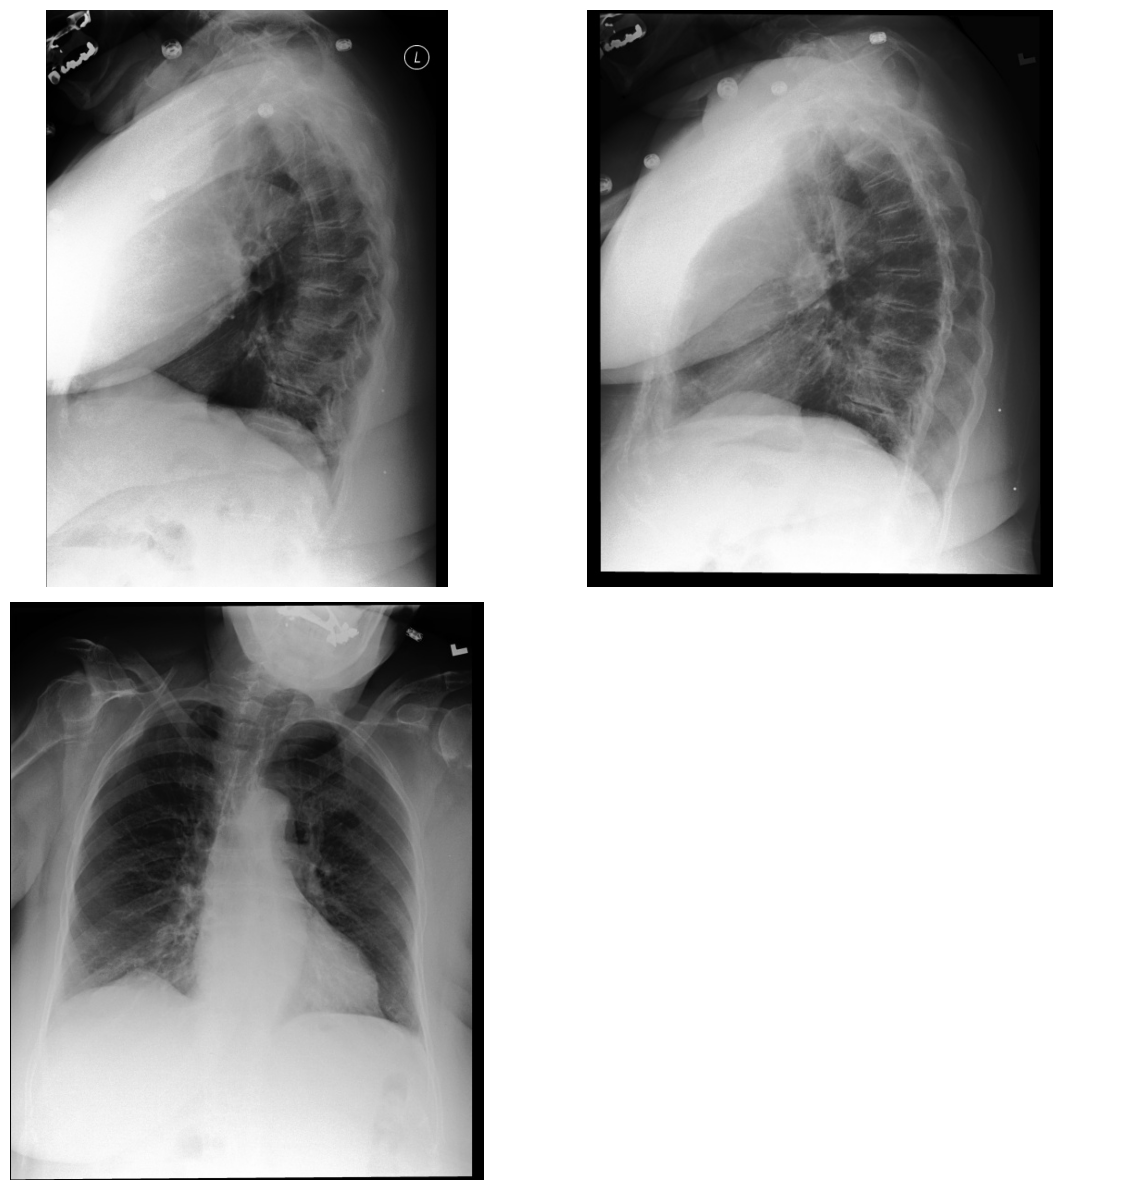

In [93]:
ridx = random.choice(strong_neg_report_idxs_with_anchor)
assert ridx not in conflicting_ridxs
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.5

ridx: 60007
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p12/p12390274/s53620470/d46890c5-e0ba0794-c9a0ca2b-60e7fe55-d2d81ade.jpg


### Radiology Report

```
FINAL REPORT
 INDICATION:  ___ year old woman with h/o dCHF, ILD with new O2 requirement  //
 eval for volume overload/any new consolidations
 
 TECHNIQUE:  Frontal view of the chest
 
 COMPARISON:  ___
 
 FINDINGS: 
 
 Inspiration is better than before. Mild pulmonary edema similar to before. 
 Enlarged cardiomediastinal silhouette is unchanged.  No new consolidation is
 identified.  There is no pneumothorax or large pleural effusion.
 
 IMPRESSION: 
 
 Mild pulmonary edema is similar to before.  Improved inspiration.
```

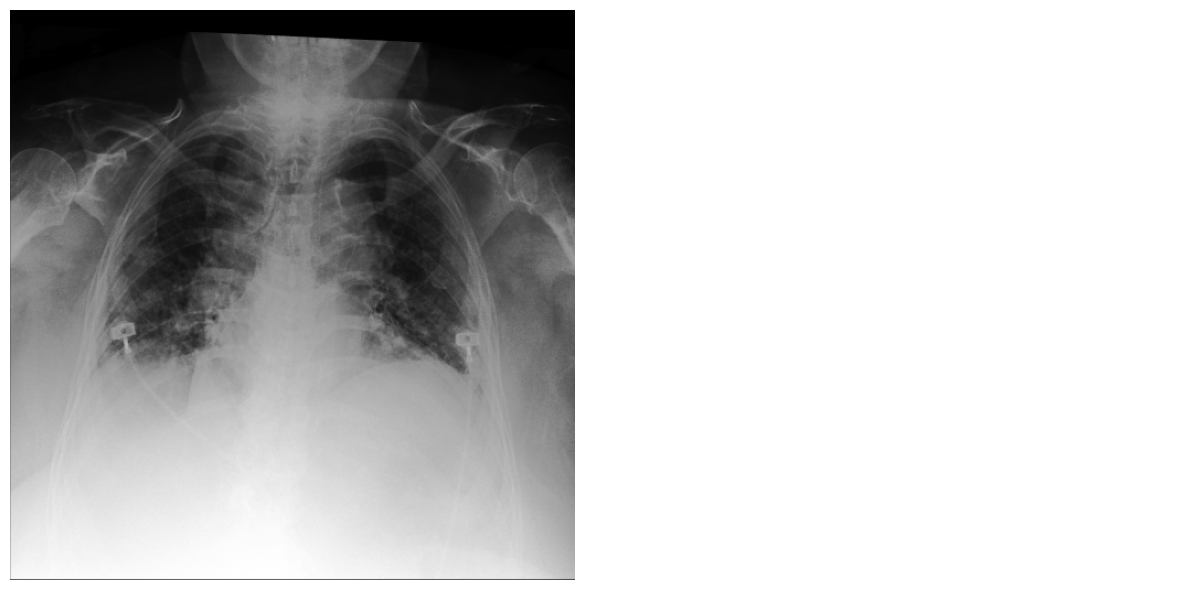

In [94]:
ridx = random.choice(weak_neg_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.6

ridx: 122214
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15180261/s51167510/134ca7e4-64c1e49a-4a2a36ac-b38264af-61addf9f.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15180261/s51167510/87cf58d0-e84ddd98-beeae5b5-7fa98afd-ea0ca3c8.jpg


### Radiology Report

```
FINAL REPORT
 INDICATION:   ___F with MVC does not remember entire event. headache, pain with
 expiration  // eval for traumatic injury
 
 TECHNIQUE:  PA and lateral views of the chest.
 
 COMPARISON:  ___.
 
 FINDINGS: 
 
 The lungs are clear.  The cardiomediastinal silhouette is within normal
 limits.  No acute osseous abnormalities, no visualized displaced fractures. 
 Surgical clips in the right upper quadrant suggest prior cholecystectomy.
 
 IMPRESSION: 
 
 No acute cardiopulmonary process.
```

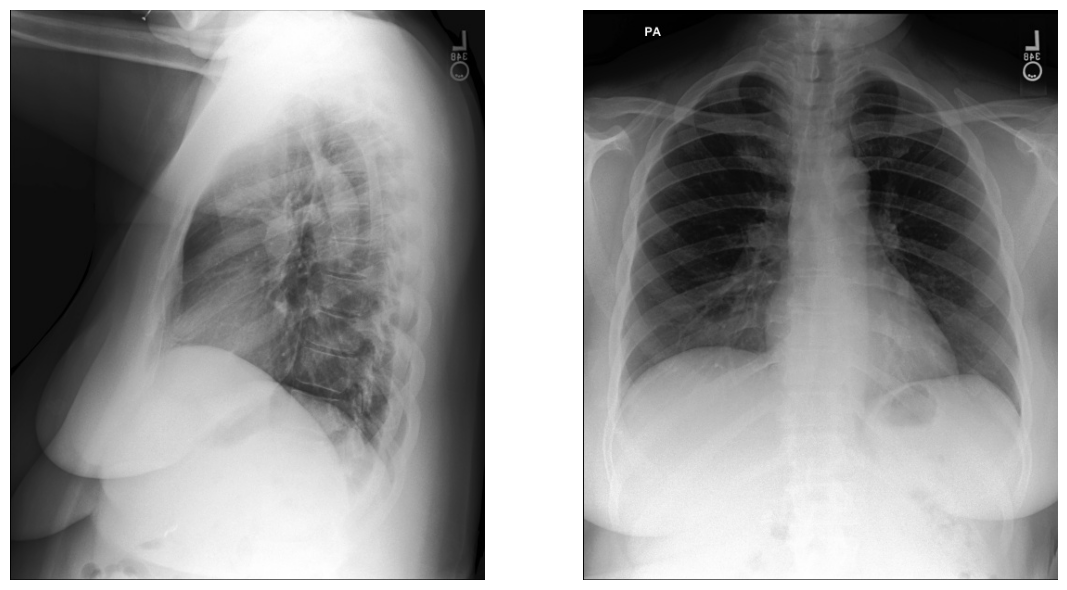

In [95]:
ridx = random.choice(weak_neg_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.7

ridx: 220949
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19751571/s59350502/db04e18f-b9893bec-f8a9c077-bcb9a532-c0df434e.jpg


### Radiology Report

```
FINAL REPORT
 HISTORY:  Status post mitral valve replacement, now with elevated white blood
 cell count.  Evaluate for interval change.
 
 TECHNIQUE:  Portable semi upright frontal chest radiograph.
 
 COMPARISON:  Chest radiographs of ___ and ___.  CT torso ___.
 
 FINDINGS: The endotracheal tube ends 3.2 cm above the carina.  A left internal
 jugular catheter and a right supraclavicular catheter terminate in the upper
 superior vena cava.
 
 Bilateral small pleural effusions are slightly improved.  There is persistent
 mild pulmonary edema which is markedly improved from ___.  Persistent
 left lower lobe collapse is unchanged from ___.  There is no
 pneumothorax.
 
 IMPRESSION: Unchanged left lower lobe collapse with continued improvement in
 mild pulmonary edema.
```

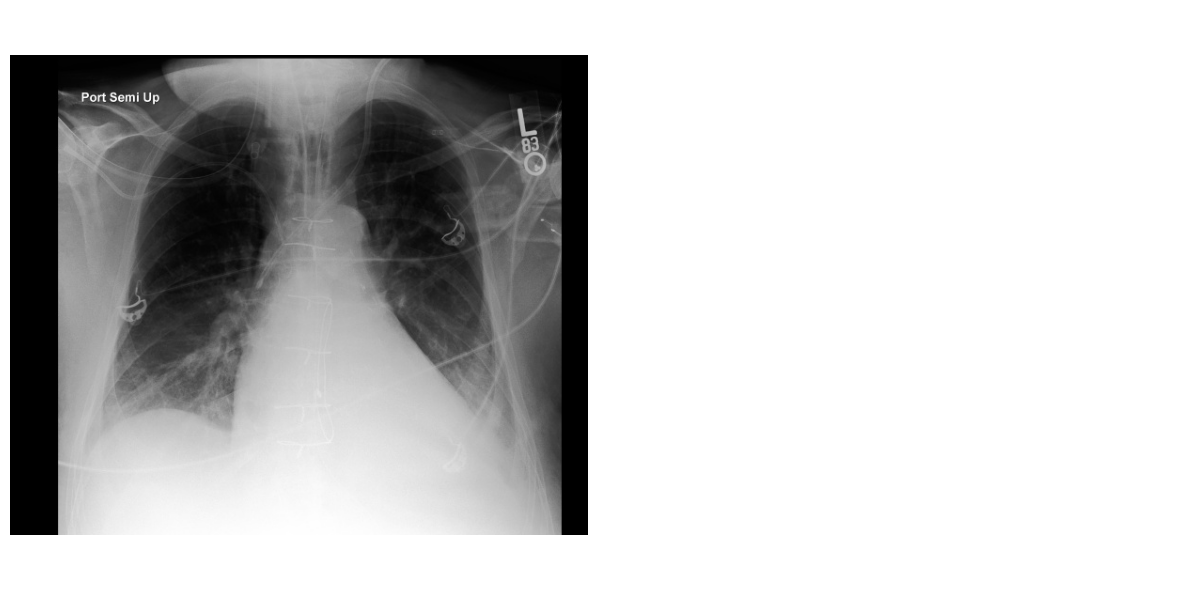

In [96]:
ridx = random.choice(weak_neg_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.8

ridx: 8132
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10670705/s59433220/2de32091-e1564931-fd4979d6-b8923071-42783fb1.jpg
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10670705/s59433220/3721a0cf-2255aaf9-6f9b3399-0a81095c-ec6597a6.jpg


### Radiology Report

```
FINAL REPORT
 EXAMINATION:  CHEST (PA AND LAT)CHEST (PA AND LAT)i
 
 INDICATION:  ___ year old woman with productive cough  // please eval for
 pneumonia
 
 COMPARISON:  Chest radiographs since ___ most recently ___
 
 IMPRESSION: 
 
 Lungs are fully expanded and clear. Heart size previously enlarged, is now
 normal. Pulmonary vasculature and pleural surfaces are unremarkable. There may
 be granulomatous lymph node calcifications in both hila, but there is no
 evidence of active infection.
```

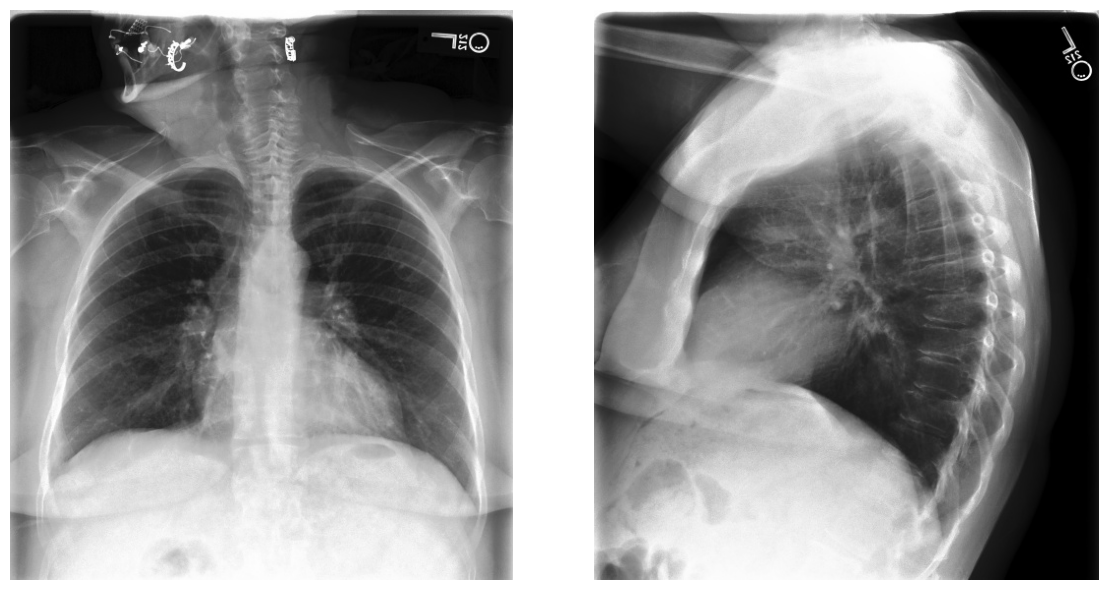

In [97]:
ridx = random.choice(weak_neg_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)

### Example 2.9

ridx: 59265
/mnt/workspace/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p12/p12206709/s50917193/69ea1608-8889780a-dc44d225-7162e415-0e62d73f.jpg


### Radiology Report

```
FINAL REPORT
 CHEST RADIOGRAPH
 
 INDICATION:  Status post thoracoscopy and pleurodesis, evaluation for interval
 change of a known right pneumothorax.
 
 COMPARISON:  ___.
 
 FINDINGS:  As compared to the previous radiograph, there is an unchanged
 appearance of the approximately 5 mm right apical pneumothorax.  The areas of
 adjacent pleural thickening and pleural thickening at the right lung base,
 combined to areas of atelectasis is also constant.  Constant appearance of the
 two right chest tubes.
```

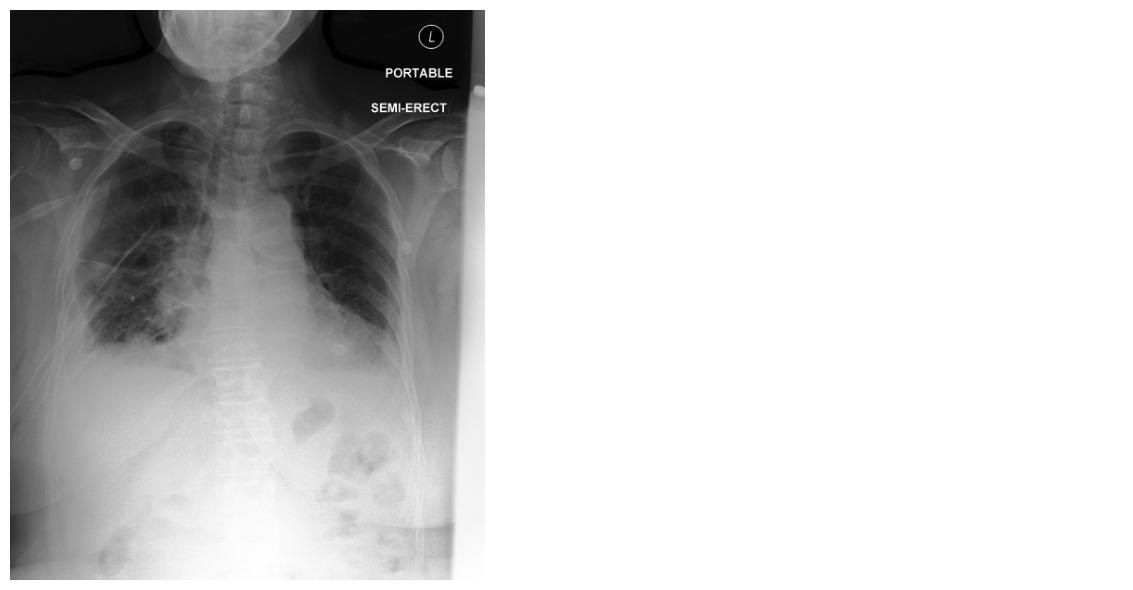

In [98]:
ridx = random.choice(weak_neg_report_idxs_with_anchor)
report_text, image_paths = get_report_text_and_images(ridx)
print(f'ridx: {ridx}')
for image_path in image_paths:
    print(image_path)
visualize_report_and_images(report_text, image_paths)